### Lensless Camera - Analysis Code (Gradient Based Optimization)

$\newcommand\measurementvec{\mathbf{b}}
\newcommand\measurementmtx{\mathbf{A}}
\newcommand\imagevec{\mathbf{v}}
\newcommand\psf{\mathbf{h}}
\newcommand{\crop}{\mathbf{C}}
\newcommand\full{\mathbf{A}}
\newcommand{\ftpsf}{\mathbf{H}}$
This program is used to analyze the raw data captured by our homemade DiffuserCam. The code works by loading in a single post-captured PSF and a single image contianing the raw data from the lensless camera. The program solves an inverse problem to construct an estimate of what the true scene should be using optimization techniques. We only focus on five gradient descent based optimization algorithms (some use default setting others are custom variations):

1. Gradient descent (GD)
1. Nesterov Momentum (NEST)
1. Nesterov Accelerated Gradient (NAG)
1. Adaptive Moment Estimation (ADAM)
1. Fast Iterative Shrinkage-Thresholding Algorithm (FISTA)

The structure of the program is outlines in the following steps:
1. Load in psf and raw data
1. Convert images to grayscale, remove background sensor noise, downsample if necessary using LANCZOS4 method.
1. Pad the PSF with zeros increasing the size of the image to next largest power of 2 compared to its original length
1. Take the Fourier transform of padded PSF image and complex conjugate of it. This results in calcualting the adjoint of the PSF image which is needed for the gradient calculation
1. Choose the optimization algorithm you want to run, and load in preset intial conditions
1. Calcaulate the gradient using $ \nabla_\imagevec \  g(\imagevec) = \full^H (\full\imagevec-\measurementvec)$ where $\full^H$ is the adjoint of $\full$, $\measurementvec$ is the raw data, and $\imagevec$ is the estimate true image of the captured scene. Within the gradient calcualtion the convolution needs to be evaluated. This is done in the frequency domain due to the convolution turning into multiplication.
1. Update estimate of true image $\imagevec$ using optimization algorithm. Repeat this process for specified number of iterations
1. User can choose to run reconstuction using any number of optimization algorithms
1. Reconstruction time, $L_2$ loss, iteration number, and downsample factor are stored in table
1. Recontructed images are all saved along with $L_2$ loss per epoch plot contianing infromation about all executed optimization algorithms.

To run this program you need to have the approperiate psf and raw data images in your working directory. This program was written by Sean Farrell, Ahmed Imtiaz, Zaid Tasneem, and modified from the framework introduced by Antipa et al.'s work on the DiffuserCam project.

Date: 11/20/19

Citation: Grace Kuo*, Nick Antipa*, Ren Ng, and Laura Waller. "DiffuserCam: Diffuser-Based Lensless Cameras." Computational Optical Sensing and Imaging. Optical Society of America, 2017. 

Github repo link: https://github.com/Waller-Lab/DiffuserCam-Tutorial



#### Helpful Debugging, Plotting, and Loading Data Functions

In [0]:
# Pausing function

def pause():
    programPause = input("Press the <ENTER> key to continue...")

#Example of using the pausing function
#print("Think about what you ate for dinner last night...")
#pause()

In [0]:
# Plotting function

def plot_fun(img,pause_bool):
  g = plt.figure(1)
  plt.imshow(img, cmap='gray')
  display.display(g)
  display.clear_output(wait=True)
  if (pause_bool == True):
    pause()


In [0]:
# Case - Switch function for file names
def fileNameToPath(filename):
  switcher ={
    "sean_hand1" : "./sean_hand1.png",
    "sean_head1" : "./sean_head1.png",
    "zaid_head1" : "./zaid_head1.png",
    "dinosaur1" : "./dinosaur1.png",
    "lion1" : "./lion1.png",
    "lion_lightsON" : "./lion_lightsON.png",
    "stacked_box1" : "./stacked_box1.png",
    "owl_13in" : "./owl_13in.png",
    "owl_23in" : "./owl_23in.png",
    "owl_33in" : "./owl_33in.png",
    "owl_43in" : "./owl_43in.png"
  }
  return switcher.get(filename,"Invalid file name. Please enter valid RAW data name.")

#fileNameToPath("sean_hand1")

#### Loading and preparing our images

In [0]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import matplotlib.image as mpimg
import time


%matplotlib inline

The code takes in two color images and converts them to grayscale: a point spread function (PSF) $\texttt{psfname}$ and a sensor measurement $\texttt{imgname}$. The images can be downsampled by a factor $f$ to improve reconstruction time.

In [0]:
#select which photos you want to run (psf, raw data)
psf_name = "exp_1" #"tutorial_test" # or "exp_1"

'''NAMES: sean_hand1, sean_head1, zaid_head1, ahmed_head1, dinosaur1,
lion1, lion_lightsON, sean_head2, sean_head3, owl1, owl2, stacked_box1,
box_lightsON, owl_13in, owl_23in, owl_33in, owl_43in'''
data_name = "dinosaur1"

# run the tutorial results
if (psf_name == "tutorial_test"):
  psfname =  "./psf_sample.tif"
  imgname =  "./rawdata_hand_sample.tif"

# run our experimental results
elif (psf_name == "exp_1"):
  psfname = "./psf_test1.png"
  # set up raw data file path
  imgname = fileNameToPath(data_name)
else:
  print("Please enter valid PSF name: tutorial_test or exp_1")

# Downsampling factor (used to shrink images)
#f = 1/2 
factor = 1

# Number of iterations
iters = 200

In [0]:
def loaddata(show_im=True):
    cv2.destroyAllWindows()
    psf = Image.open(psfname)
    psf = cv2.imread(psfname,0)
    '''psf = cv2.imread(psfname)
    psf = psf[:,:,0]    #extracts only the green channel from BGR image'''
    psf = np.rot90(np.rot90(psf))
    psf = np.array(psf, dtype='float32')

    data = Image.open(imgname)
    data = cv2.imread(imgname,0)
    '''data = cv2.imread(imgname)
    data = data[:,:,0]    #extracts only the green channel from BGR image'''
    data = np.rot90(np.rot90(data))
    data = np.array(data, dtype='float32')
    
    print("This is PSF_SHAPE: "+ str(psf.shape))
    print("This is DATA_SHAPE: "+str(data.shape))

    '''Convert the captured colored images to gray scale '''

    '''psf = rgb2gray(psf)
    data = rgb2gray(data)
    print("This is RGB2G PSF_SHAPE: "+ str(psf.shape))
    print("This is RGB2G DATA_SHAPE: "+str(data.shape))
    pause()
    plot_fun(psf, True)
    plot_fun(data, True)'''

    """In the picamera, there is a non-trivial background 
    (even in the dark) that must be subtracted"""
    bg = np.mean(psf[5:15,5:15]) 
    psf -= bg
    data -= bg
    
    """Resize to a more manageable size to do reconstruction on. 
    Because resizing is downsampling, it is subject to aliasing 
    (artifacts produced by the periodic nature of sampling). Demosaicing is an attempt
    to account for/reduce the aliasing caused. In this program we use the LANCZOS method 
    because of its anialising properties""" 
    
    psf_internal = internal_resize(psf,factor)
    data_internal = internal_resize(data,factor)
    
    psf = psf_internal
    data = data_internal
    
    """Now we normalize the images so they have the same total power. Technically not a
    necessary step, but the optimal hyperparameters are a function of the total power in 
    the PSF (among other things), so it makes sense to standardize it"""
    
    psf /= np.linalg.norm(psf.ravel())
    data /= np.linalg.norm(data.ravel())
    print("This is the max normalized value of PSF: "+ str(np.max(psf)))
    print("This is the max normalized value of data: "+ str(np.max(data)))
    #pause()
    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')
        display.display(fig1)
        fig2 = plt.figure()
        plt.imshow(data, cmap='gray')
        plt.title('Raw data')
        display.display(fig2)
    return psf, data
    

In [0]:
import cv2

''' Types of interpolations inside cv2 are:
  1) INTER_NEAREST
  2) INTER_LINEAR
  3) INTER_AREA
  4) INTER_CUBIC
  5) INTER_LANCZOS4
'''
def internal_resize(img, factor):
  #factor = int(np.log2(factor))
  width = int(img.shape[0]/factor)
  height = int(img.shape[1]/factor)
  out_dim = (height,width)
  img_out = cv2.resize(img,out_dim, interpolation = cv2.INTER_LANCZOS4)
  print(img_out.shape)
  return img_out

### Calculating convolutions using $\texttt{fft}$
We want to calculate convolutions efficiently. To do this, we use the "fast fourier transform" $\texttt{fft2}$ which computes the Discrete Fourier Transform (DFT). The convolution theorem for DFTs only holds for circular convolutions. We can still recover a linear convolution by first padding the input images then cropping the output of the inverse DFT:
\begin{equation}
h*x=\mathcal{F}^{-1}[\mathcal{F}[h]\cdot\mathcal{F}[x]] = \texttt{crop}\left[\ \texttt{DFT}^{-1}\left\{\ \texttt{DFT} [\ \texttt{pad}[h]\ ]\cdot\texttt{DFT}[\ \texttt{pad}[x]\ ]\ \right\} \ \right]
\end{equation}

Recovering the linear convolution correctly requires that we double the dimensions of our images. To take full advantage of the speed of the $\texttt{fft2}$ algorithm, we actually pad $\texttt{full_size}$, which is the nearest power of two that is larger than that size.

We have chosen $\texttt{full_size}$ in such a way that it provides enough padding to make circular and linear convolutions look the same <i>after being cropped back down to</i> $\texttt{sensor_size}$. That way, the "sensor crop" due to the sensor's finite size and the "fft crop" above are the same, and we just need one crop function.

Along with initialization, we compute $\texttt{H} = \texttt{fft2}(\texttt{hpad})$ and $\texttt{Hadj} = \texttt{H}^*$, which are constant matrices that will be needed to calculate the action of $\measurementmtx$ and $\measurementmtx^H$ at every iteration. 

Lastly, we must take into account one more practical difference. In imaging, we often treat the center of the image as the origin of the coordinate system. This is theoretically convenient, but fft algorithms assume the origin of the image is the top left pixel. The magnitude of the fft doesn't change because of this distinction, but the phase does, since it is sensitive to shifts in real space. An example with the simplest function, a delta function, is displayed below. In order to correct this problem, we use $\texttt{ifftshift}$ to move the origin of an image to the top left corner and $\texttt{fftshift}$ to move the origin from the top left corner to the center. 

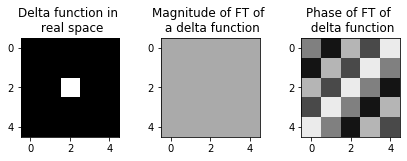

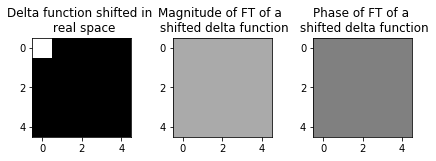

In [0]:
def no_shift():
    delta = np.zeros((5,5))
    delta[2][2] = 1
    fft_mag = np.abs(fft.fft2(delta))
    fft_arg = np.angle(fft.fft2(delta))
    
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.tight_layout()
    ax[0].imshow(delta, cmap='gray')
    ax[0].set_title('Delta function in \n real space')

    ax[1].imshow(fft_mag,vmin=-3,vmax=3,cmap='gray')
    ax[1].set_title('Magnitude of FT of \n a delta function')
    
    ax[2].imshow(fft_arg,vmin=-3,vmax=3,cmap='gray')
    ax[2].set_title('Phase of FT of \n delta function')
    
no_shift()   

def shift():
    delta = np.zeros((5,5))
    delta[2][2] = 1
    delta_shifted = fft.ifftshift(delta)
    fft_mag = np.abs(fft.fft2(delta_shifted))
    fft_arg = np.angle(fft.fft2(delta_shifted))
    
    fig2, ax2 = plt.subplots(nrows=1, ncols=3)
    fig2.tight_layout()
    ax2[0].imshow(delta_shifted, cmap='gray')
    ax2[0].set_title('Delta function shifted in \n real space')

    ax2[1].imshow(fft_mag,vmin=-3,vmax=3,cmap='gray')
    ax2[1].set_title('Magnitude of FT of a \n shifted delta function')
    
    ax2[2].imshow(fft_arg,vmin=-3,vmax=3,cmap='gray')
    ax2[2].set_title('Phase of FT of a \n shifted delta function')
    
shift()

### For this notebook and the ADMM notebook, we follow the following convention so we don't have to worry about this issue again:
1. All images in _real_ space are stored with the origin in the center (so they can be displayed correctly)
2. All images in _Fourier_ space are stored with the origin in the top left corner (so they can be used for processing correctly)
3. The above rules mean that, to perform a convolution between two real space images $h$ and $x$, we do $$\texttt{fftshift}( \texttt{ifft} [\texttt{fft}[ \texttt{ifftshift}(h) \cdot \texttt{ifftshift}(x) ] ] )$$ instead of $$\texttt{ifft}[\texttt{fft}[h \cdot x]]$$
The rules imply that if we store the fourier transform of $h$ for future use, instead of storing $\texttt{fft}[h]$, we store $\texttt{fft}[\texttt{ifftshift}(h)]$.

In [0]:
def initMatrices(h, wait):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start

    # Determine how much the input PSF needs to be padded with zeros
    init_shape = h.shape
    print("This is the Init_shape: "+str(init_shape))
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    print("This is the padded_shape: "+str(padded_shape))
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h
    #print(str(hpad[1,1]))
    #print(str(hpad[100,100]))

    H = fft.fft2(fft.ifftshift(hpad), norm="ortho")   #this calcualtes takes fourier transform of psf within padding
    Hadj = np.conj(H)
    # Debugging code prints variable sizes
    '''print("This is the Hadj: "+str(Hadj.shape))
    print("This is the Hadj[1,1]: " + str(Hadj[1,1]))
    print("This is the Hadj[100,100]: " + str(Hadj[100,100]))
    #print original h values at same locations
    print("This is the h[1,1]: " + str(h[1,1]))
    print("This is the h[100,100]: " + str(h[100,100]))'''

    #Used to remove zero padding
    def crop(X):
        return X[starti:endi, startj:endj]
        
    #Used to apply zero padding
    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    print("This is the v: "+str(v.shape))
    if (wait == True):
      pause()

    return H, Hadj, v, utils

def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

#### Computing the gradient

The most important step in Gradient Descent is calculating the gradient
$$ \nabla_\imagevec \  g(\imagevec) = \full^H (\full\imagevec-\measurementvec)$$
We do this in 2 steps:
1. We compute the action of $\full$ on $\imagevec$, using $\texttt{calcA}$
2. We compute the action of $\full^H$ on $\texttt{diff} = \texttt{Av-b}$ using $\texttt{calcAHerm}$ <br/>

Here, $\texttt{vk}$ is the current padded estimate of the scene and $\texttt{b}$ is the sensor measurement.


In [0]:
def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    norm2 = np.linalg.norm(diff)  #This is the L2 norm loss
    print(norm2)
    return np.real(calcAHerm(Hadj, diff, pad))

In [0]:
def grad2(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    norm2 = np.linalg.norm(diff) #This is the L2 norm loss
    print(norm2)
    return np.real(calcAHerm(Hadj, diff, pad)), norm2

We write $\full$ as:
$$ \full\imagevec \iff \mathrm{crop} \left[ \mathcal{F}^{-1} \left\{\mathcal{F}(h) \cdot \mathcal{F}(v)\right\} \right]$$
In code, this becomes
\begin{align*} 
\texttt{calcA}(\texttt{vk}) & = \texttt{crop}\ (\texttt{ifft}\ (\texttt{fft}(\texttt{hpad}) \cdot \texttt{fft}(\texttt{vk})\ )\  )\\
& = \texttt{crop}\ (\texttt{ifft}\ (\texttt{H} \cdot \texttt{Vk}))
\end{align*}
where $\cdot$ represents point-wise multiplication

In [0]:
def calcA(H, vk, crop):
    Vk = fft.fft2(fft.ifftshift(vk))
    return crop(fft.fftshift(fft.ifft2(H*Vk)))

We first pad $\texttt{diff}$ , giving us $\texttt{xpad}$, then we take the 2D fourier transform, $\texttt{X} = \mathcal{F}(\texttt{xpad})$. The action of the adjoint of $A$ is

$$ A^H \mathbf{x} \iff \mathcal{F}^{-1} \left\{ \mathcal{F}(\psf)^* \cdot \mathcal{F}( \operatorname{pad}\left[x\right]) \right\}$$
This becomes
\begin{align*}
\texttt{calcAHerm}(\texttt{xk}) &= \texttt{ifft}\ (\ (\texttt{fft}(\texttt{h}))^H \cdot \texttt{fft}\ (\texttt{pad}(\texttt{diff}))\ ) \\
& = \texttt{ifft}\ (\texttt{Hadj} \cdot \texttt{X})
\end{align*}

In [0]:
def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(fft.ifftshift(xpad))
    return fft.fftshift(fft.ifft2(Hadj*X))  #in frequency domain convolution becomes multiplication

The function below is specifically used for the NADAM optimization algorithm

In [0]:
def PI_operator(start,end,data):
  result = 1
  for i in range(start,end):
    if(i <= iters):
      result = result*data[i]
    else:
      result = result
    #print(result)
    #print(data[i])
    i = i+1
  return result

# code below is used is for testing
'''test = np.array([1,2,3,4,5,6,7,8])
print(test)
print(type(test))
result = 1*2*3*4*5*6*7*8
print("This is what Pi notation should produce"+str(result))
PI_result = PI_operator(0,8,test)
print("This is Pi notation result"+str(PI_result))'''

'test = np.array([1,2,3,4,5,6,7,8])\nprint(test)\nprint(type(test))\nresult = 1*2*3*4*5*6*7*8\nprint("This is what Pi notation should produce"+str(result))\nPI_result = PI_operator(0,8,test)\nprint("This is Pi notation result"+str(PI_result))'

#### Constructing Gradient Descent Optimization

This is the main function, which calculates the gradients and updates our estimation of the scene:
\begin{align*}
    &\imagevec_0 = \text{ anything} \\
    &\text{for } k = 0 \text{ to num_iters:}\\
    &\quad \quad \imagevec_{k+1} \leftarrow \texttt{gradient_update}(\imagevec_k) \\
\end{align*} 

There are different ways of doing the gradient update. The three we will show are regular GD, Nesterov momentum update, and FISTA.

To guarantee convergence, we set the step size to be 
\begin{align*} 
\alpha_k &< \frac{2}{\|\measurementmtx^H \measurementmtx\|}_2 \approx \frac{2}{\lambda_{max}(\mathbf{M}^H\mathbf{M})}
\end{align*}

To calculate this, we use the property that $\mathbf{M}$ is diagonalizable by a Fourier Transform:
$$\begin{align*}
\mathbf{M}^H\mathbf{M} &= \left(\mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F}\right)^H \ \mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F} \\
&= \mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh})^* \ \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F} \\
\lambda_{max}(\mathbf{M}^H\mathbf{M}) &= \max \left(\mathrm{diag}(\mathbf{Fh})^* \ \mathrm{diag}(\mathbf{Fh}) \right)
\end{align*}$$
In code, we have
\begin{align*}
\alpha = \frac{1.8}{\texttt{max} \left(\texttt{Hadj} \cdot \texttt{H}\right)}
\end{align*}


Since we are dealing with images, one constraint on the reconstructed image $\imagevec_k$ is that all the entries have to be non-negative. We do this by doing projected gradient descent. The projection function $\texttt{proj}$ we use is non-negativity, which  projects $\texttt{vk}$ onto the non-negative halfspace.  

In [0]:
def grad_descent(h, b, opt_name, wait):
    H, Hadj, v, utils = initMatrices(h, wait)
    #load in the padding and cropping functions needed to resize results
    crop = utils[0]
    pad = utils[1]
        
    alpha = np.real(1.8/(np.max(Hadj * H)))   #determine optimal learning rate
    iterations = 0
     
    def non_neg(xi):
        xi = np.maximum(xi,0)
        return xi
    
    #proj = lambda x:x #Do no projection
    proj = non_neg #Enforce nonnegativity at every gradient step. Comment out as needed.

    l2_error = np.zeros(iters)
    error = 0   #initialize error to 0
    #print(l2_error)
    #pause()

    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v
    
    '''Below the program selects which optimization algorithm to run based on 
    the user input.'''
    #### Gradient Descent update #### 
    if (opt_name == "GD"):
      print("Using gradient descent optimization")

    #### Nesterov momentum update ####   
    elif (opt_name == "NEST"):
      print("Using Nesterov momentum optimization")
      p = 0
      mu = 0.9

    #### MY NAG (Nesterov accelerated gradient) update ####
    elif (opt_name == "NAG"):
      print("Using Nesterov accelerated momentum optimization")
      mt = 0
      mu = 0.99
      adaptive = True #boolean True or False

    #### FISTA update ################
    elif (opt_name == "FISTA"):
      print("Using FISTA = conditioned Nesterov momentum optimization")
      tk = 1
      xk = v

    #### ADAM update ################
    elif (opt_name == "ADAM"):
      vk = v
      #alpha = 0.01
      beta1 = 0.9
      beta2 = 0.999
      epsilon = 1e-06
      mt = 0
      t = 0     #time step
      vt = np.array([0])
      vth = np.array([0]) #np.zeros(padded_shape)
      amsgrad = False    #set to true or false
    
    #### NADAM update ################
    elif (opt_name == "NADAM"):
      print("Using Nesterov and Adam combined optimization")
      iteration_range = (iters*2)+2
      t_range = np.arange(iteration_range)
      vk = v
      alpha = 0.1
      mu = 0.9
      mu_t = mu*(1-(0.5*0.96**(t_range/250)))
      nu = 0.999
      epsilon = 1e-07
      mt = 0
      t = 0     #time step
      vt = np.array([0]) 
    else:
      print("Invalid optimization algorithm name.")
    
    '''Perform optimization iterations'''
    for iterations in range(iters):   
        
        if (opt_name == "GD"):
          vk, error = gd_update(vk, parent_var)
        elif (opt_name == "NEST"):
          vk, p, error = nesterov_update(vk, p, mu, parent_var)
        elif (opt_name == "NAG"):
          vk, mt, error = nag_update(vk,mu,mt,parent_var, adaptive)
        elif (opt_name == "FISTA"):
          vk, tk, xk, error = fista_update(vk, tk, xk, parent_var)
        elif (opt_name == "ADAM"):
          vk,beta1,beta2,mt,vt,epsilon,t,error = adam_update(vk,beta1,beta2,mt,vt,vth,epsilon,parent_var,amsgrad,t)
        elif (opt_name == "NADAM"):
          vk,mt,vt,t,error = nadam_update(vk,mt,vt,mu,nu,mu_t,epsilon,parent_var,t)
        else:
          print("Please enter valid optimization name")

        if iterations % 10 == 0:
            image = proj(crop(vk))
            f = plt.figure(1)
            plt.imshow(image, cmap='gray')
            plt.title('Reconstruction after iteration {}'.format(iterations))
            display.display(f)
            display.clear_output(wait=True)
 
        l2_error[iterations] = error
    
    
    return proj(crop(vk)), l2_error 
    

#### Gradient descent algorithms

##### Regular Gradient Descent (GD)
Regular gradient descent is simply following the negative of the gradient until we reach the minimum:

\begin{align*}
    & \texttt{gradient_update}(\imagevec_k): \\
    &\quad \quad\imagevec'_{k+1} \leftarrow \imagevec_k - \alpha_k \full^H(\full\imagevec_k - \measurementvec) \\
    &\quad \quad \imagevec_{k+1} \leftarrow \operatorname{proj}_{\imagevec \geq 0} (\imagevec_{k+1}')
\end{align*} 

In [0]:
def gd_update(vk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    [gradient, error] = grad2(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    vk = proj(vk)
    
    return vk, error    

##### Nesterov Momentum (NEST)
GD works but it's slow. One way to speed it up is to consider a velocity term, $\mathbf{p}$. Each update becomes:

\begin{align*}
    &\texttt{gradient_update}(\imagevec_k): \\
    &\qquad \mathbf{p}_{k+1} \leftarrow \mu \mathbf{p}_k - \alpha_k \texttt{grad}(\imagevec_k) \\
    &\qquad \imagevec_{k+1}' \leftarrow \imagevec_k - \mu \mathbf{p}_{k} + (1+\mu)\mathbf{p}_{k+1} \\
    &\qquad \imagevec_{k+1} \leftarrow \operatorname{proj}_{\imagevec \geq 0} (\imagevec_{k+1}')
\end{align*}

The parameter $\mu$ is called the momentum and is strictly between 0 and 1.

In [0]:
def nesterov_update(vk, p, mu, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    p_prev = p
    [gradient, error] = grad2(Hadj, H, vk, b, crop, pad)
    p = mu*p - alpha*gradient
    vk += -mu*p_prev + (1+mu)*p
    vk = proj(vk)
    
    return vk, p, error

##### Nesterov Accelerated Gradient (NAG)
\begin{align*}
    \textrm{REGULAR MODE:}&\\
    &\texttt{gradient_update}(\imagevec_k): \lbrace\\
    &\qquad\hat{v}_k = v_k - \eta\mu (m_t)\\
    &\qquad m_{t+1} = \mu(m_t) + \eta\nabla_vg(\hat{v}_k)\\
    &\qquad v_{k+1} = v_k - \eta (m_{t+1})\rbrace
\end{align*}

\begin{align*}
    \textrm{ADAPTIVE MODE:}&\\
    &\texttt{gradient_update}(\imagevec_k):\lbrace\\
    &\qquad\hat{v}_k = v_k - \eta\mu (m_t)\\
    &\qquad [\textrm{grad}_m, L_{2,m}] = \nabla_vg(\hat{v}_k)\\
    &\qquad [\textrm{grad}_r, L_{2,r}] = \nabla_vg(v_k)\\
    %adaptive section comparing L2 norm loss between gradients
    &\qquad \textrm{if }(L_{2,m} \leq L_{2,r})\lbrace\\
    &\qquad \quad m_{t+1} = \mu(m_t) + \eta(\textrm{grad}_m)\\
    &\qquad\quad v_{k+1} = v_k - \eta (m_{t+1})\rbrace\\
    &\qquad \textrm{else}\lbrace\\
    &\qquad\quad v_{k+1} = v_k - \eta (\textrm{grad}_r)\\
    &\qquad\quad m_{t+1} = 0\rbrace\\
\end{align*}

In [0]:
def nag_update(vk,mu,mt,parent_var, adaptive):
  H, Hadj, b, crop, pad, alpha, proj = parent_var
  if (adaptive == False):
    eta = alpha
    vk_hat = vk - (eta*mu*mt)
    [gradient, error]  = grad2(Hadj,H,vk_hat,b,crop,pad)
    mt1 = mu*mt + gradient
    vk = vk - (eta*mt1)#(mt1)#(eta*mt1)
    mt = mt1

  if (adaptive == True):
    eta = alpha
    vk_hat = vk - (eta*mu*mt)
    [gradient, norm2_momentum] = grad2(Hadj,H,vk_hat,b,crop,pad)
    [grad_old, norm2_old] = grad2(Hadj,H,vk,b,crop,pad)
    if (norm2_momentum <= norm2_old):
      error = norm2_momentum
      mt1 = mu*mt + gradient
      vk = vk - (eta*mt1)
      mt = mt1
    else:
      print("Im in adpative statement")
      error = norm2_old
      vk = vk - (eta*grad_old)
      mt = 0
        
  '''gradient = grad(Hadj,H,vk,b,crop,pad)
  mt1 = mu*mt + eta*gradient
  vk = vk - (mu*mt1+eta*gradient)'''
  #mt = mt1
  return vk,mt,error

##### Fast Iterative Shrinkage-Thersholding Algorithm (FISTA)
Instead of Nesterov momentum, we can use FISTA, which speeds up the iterative process. Each iteration of the algorithm is as follows:

\begin{align*}
    &\texttt{gradient_update}(\imagevec_k):\\
    &\qquad \imagevec_k \leftarrow \imagevec_k - \alpha_k \texttt{grad}(\imagevec_k) \\ 
    &\qquad x_{k} \leftarrow \texttt{proj}(\imagevec_k) \\
    &\qquad t_{k+1} \leftarrow \frac{1+\sqrt{1+4t_k^2}}{2} \\
    &\qquad \imagevec_{k+1} \leftarrow x_{k} + \frac{t_k-1}{t_{k+1}} (x_{k}-x_{k-1}) \\
\end{align*}


In [0]:
def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    x_k1 = xk
    [gradient, error] = grad2(Hadj, H, vk, b, crop, pad)
    #gradient = grad(Hadj, H, vk, b, crop, pad) ; error =0
    yk = vk
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    #adaptive restart momentum check  
    '''test = np.dot(np.transpose((yk - xk)),(xk-x_k1))#Adaptive step works but slows algorithm down x2
    if (np.min(test) > 0):    #grad_test > 0
      print("Im in restart loop")
      vk = xk
      xk = vk 
      tk =1
    else:
      t_k1 = (1+np.sqrt(1+4*tk**2))/2
      vk = xk+(tk-1)/t_k1*(xk - x_k1)
      tk = t_k1'''
    
    return vk, tk, xk, error

##### Adaptive Moment Estimation Optimizer (ADAM)
\begin{align*}
    &\texttt{gradient_update}(\imagevec_k):\lbrace\\
    &\qquad t = k+4\\
    &\qquad\textrm{LR} = \eta\sqrt{\frac{1-\beta_2^t}{1-\beta_1^t}} \tag{LR = learning rate}\\
    &\qquad m_{k+1} = \beta_1(m_k) + (1-\beta_1)\nabla_vg(v_k)\\
    &\qquad n_{k+1} = \beta_2{n_k} + (1-\beta_2)\nabla_vg(v_k)\nabla_vg(v_k)\\
    &\qquad p_{k+1} = \mu p_k - \eta\nabla_vg(v_k)\\
    &\qquad y_{k+1} = v_k - \textrm{LR}\frac{m_{k+1}}{\sqrt{n_{k+1}}+\epsilon}\\
    &\qquad v_{k+1} = \underset{v \geq 0}{\textrm{proj}}(y_{k+1})\rbrace
\end{align*}

In [0]:
def adam_update(vk, beta1, beta2, mt, vt, vth, epsilon, parent_var, amsgrad, t):
  H, Hadj, b, crop, pad, alpha, proj = parent_var
  t = t+4
  learn_rate = alpha * (np.sqrt(1-beta2**t)/(1-beta1**t))
  [gradient, error] = grad2(Hadj, H, vk, b, crop, pad)
  mt1 = beta1*mt + (1-beta1)*gradient
  vt1 = beta2*vt + (1-beta2)*gradient*gradient
  #perform gradient update
  if (amsgrad == True):
    #print(type(vt))
    #print(type(vth))
    #pause()
    vth1 = np.maximum(vth,vt1)
    vk -= learn_rate*mt1/(np.sqrt(vth1)+epsilon)
    vth = vth1
  else:
    vk -= learn_rate*mt1/(np.sqrt(vt1)+epsilon)
  #vk -= learn_rate*mt1/(np.sqrt(vt1)+epsilon)
  vk = proj(vk)    #projection step
  #t = t+1
  vt = vt1
  mt = mt1
  return vk, beta1, beta2, mt, vt, epsilon, t, error


##### Nesterov-accelerated adaptive moment estimation (NADAM)

In [0]:
def nadam_update(vk, mt, vt, mu, nu, mu_t, epsilon, parent_var, t):
  H, Hadj, b, crop, pad, alpha, proj = parent_var
  t = t+2
  [gradient, error] = grad2(Hadj, H, vk, b, crop, pad)
  grad_h = gradient/(1-PI_operator(1,t,mu_t))
  mt1 = mu*mt + (1-mu)*gradient
  mt1_h = mt1/(1 - PI_operator(1,t+1,mu_t))
  vt1 = nu*vt + (1-nu)**gradient
  vt1_h = vt1/(1-nu**t)
  mt1_b = (1-mu_t[t])*grad_h + mu_t[t+1]*mt1_h
  vk = vk - alpha*(mt1_b/(np.sqrt(vt1_h)+epsilon))
  vk = proj(vk)

  
  vt = vt1
  mt = mt1
  return vk,mt,vt,t,error



#### Running the Optimization Algorithm(s) and Reconstructing Scene Image

##### The code below performs the reconstruction for one optimization algorithm

0.01251054734652966
0.01254116735238338
0.012476625544267358
0.012508478826482632
0.012441547477903863
0.01247458532986613
0.012405386407372954
0.012439543966464966
0.012368229790876569
0.012403427412920963
0.012330177492285758
0.012366322394365538
0.012291339773350682
0.012328327909304838
0.012251835126394979
0.012289553246281722
0.012211788013312377
0.012250115847011014


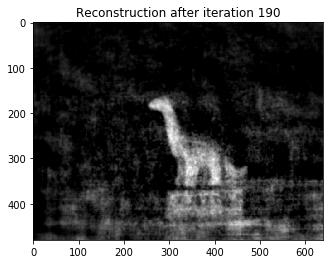

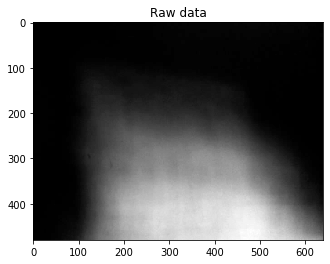

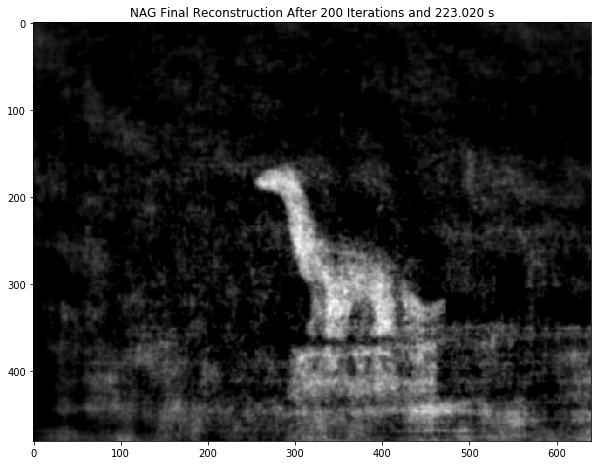

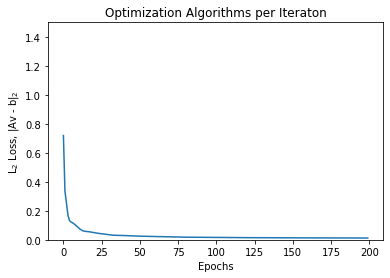

It took 223.020 s. to reconstruct the estimated true image


In [0]:
#run reconstruction algorithom for any one optimization method
optimizer_test = np.array(["GD", "NEST", "NAG", "FISTA", "ADAM", "NADAM"])
wait = True
index = 2 #select which optimization algorithm you want to run 0-5
psf, data = loaddata()
tic = time.time()
[final_im, l2_error] = grad_descent(psf, data, optimizer_test[index], wait)
tac = time.time()
time_elapse = tac-tic
plt.figure(figsize=(10,10))
plt.imshow(final_im, cmap='gray')
plt.title(optimizer_test[index]+' Final Reconstruction After {} Iterations'.format(iters)+' and %.3f s'%time_elapse)
display.display()
plt.savefig(data_name+'_'+optimizer_test[index]+'_image.pdf')



#plot the loss as function of iteration
plt.figure()
t_range = np.arange(iters)
plt.plot(t_range,l2_error)
plt.xlabel('Epochs')
plt.ylabel("L$_2$ Loss, |Av - b|$_2$")
plt.title("Optimization Algorithms per Iteraton")
plt.ylim(0,1.5)
plt.show()


#create table with optimization algorithm and reconstruction time
print('It took %.3f s. to reconstruct the estimated true image' % (tac-tic))


##### The code below performs the reconstruction for ALL optimizatiom algorithms

0.06206382814302045
0.062059396432614135
0.06205506330960596
0.06205082476057796
0.06204666711117261
0.062042608418938335
0.06203863486990296
0.06203474663948179
0.062030929663798244


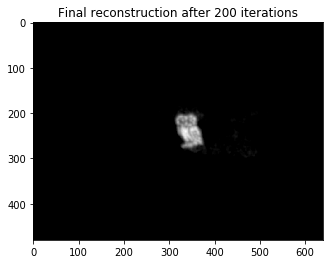

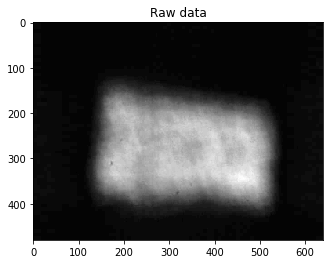

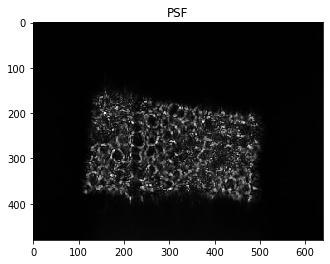

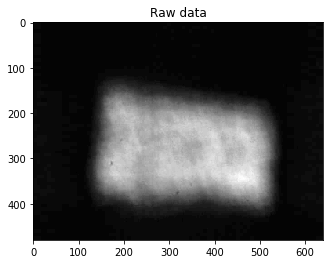

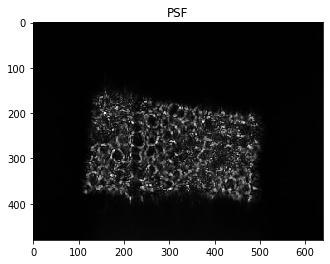

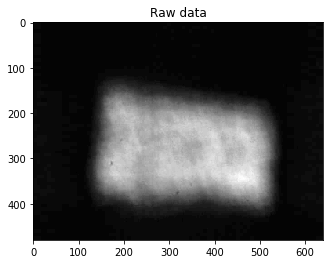

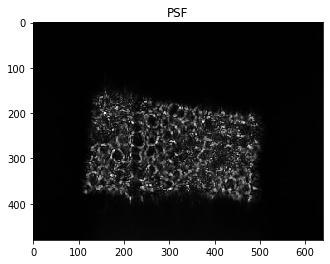

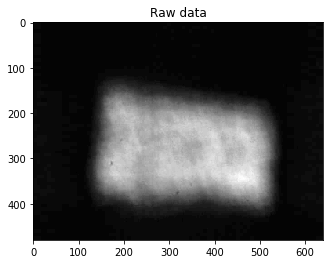

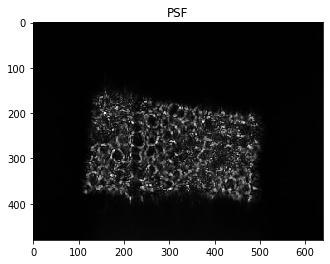

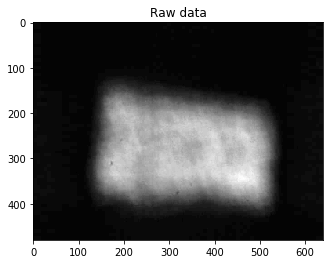

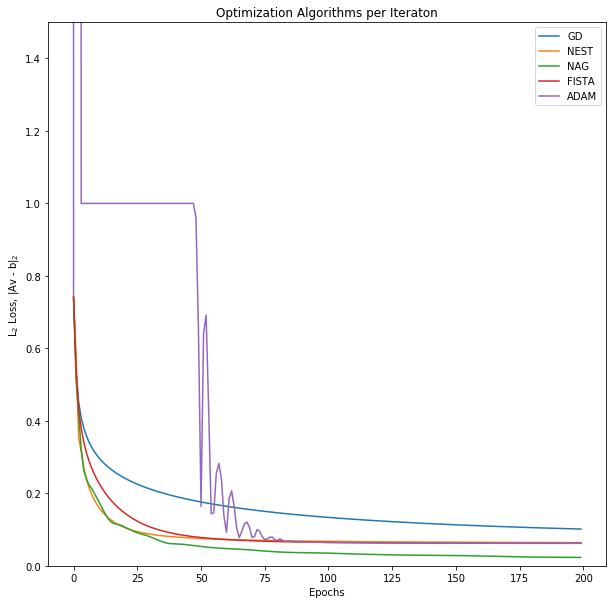

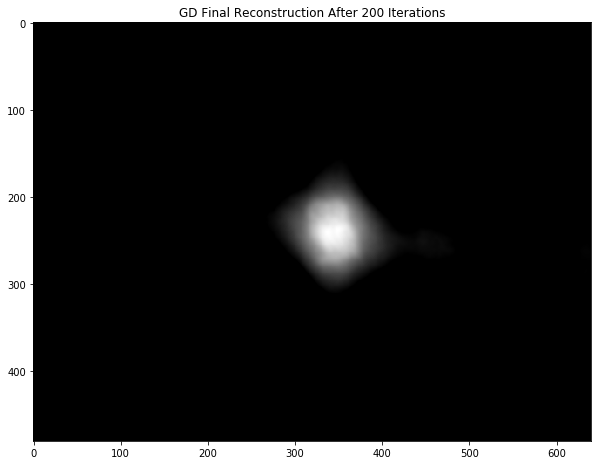

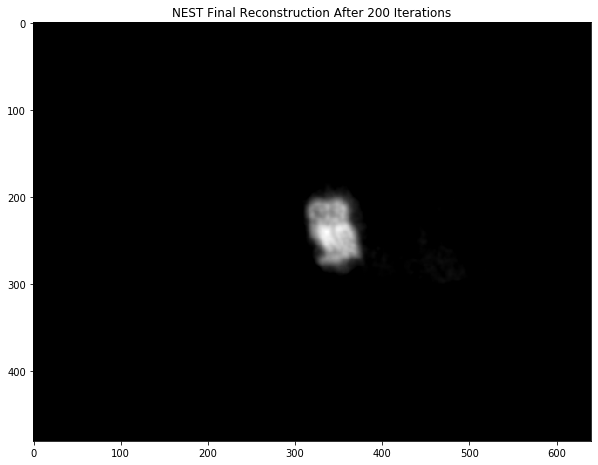

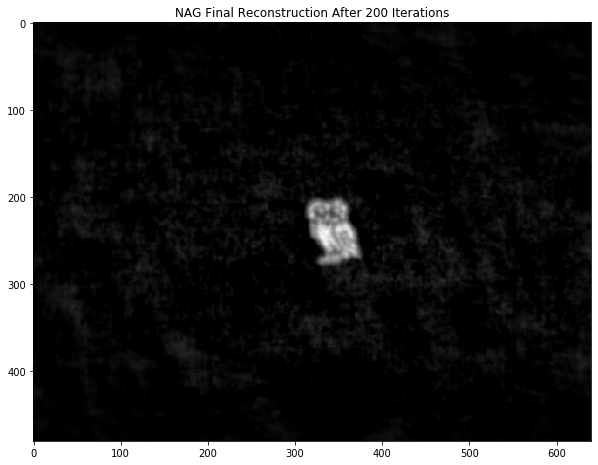

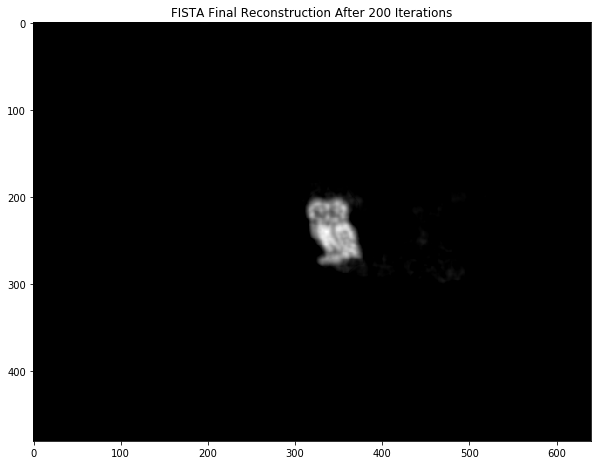

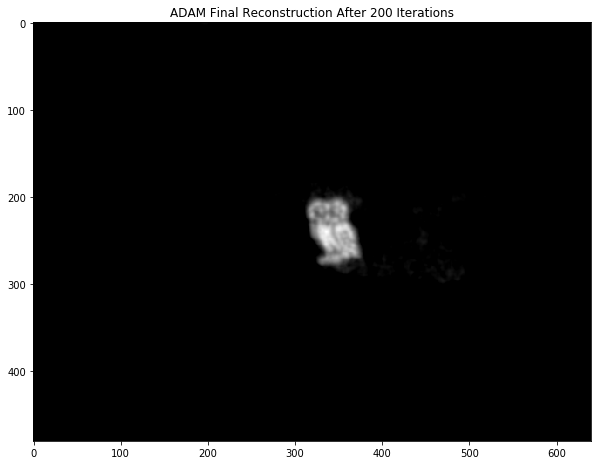

In [0]:
#run reconstruction algorithom for ALL optimization methods
optimizer_test = np.array(["GD", "NEST", "NAG", "FISTA", "ADAM"])
final_results = list()
wait = False
for i in range(optimizer_test.shape[0]):
  psf, data = loaddata()
  tic = time.time()
  [final_im, l2_error] = grad_descent(psf, data, optimizer_test[i], wait)
  tac = time.time()
  plt.imshow(final_im, cmap='gray')
  plt.title('Final reconstruction after {} iterations'.format(iters))
  display.display()
  time_elapse = tac-tic
  result = (optimizer_test[i],time_elapse,l2_error,final_im)
  final_results.append(result)

'''Structure of final_results tuple: optimizer name (0), reconstruction time (1),
 L2 error array (2), and final reconstructed image (3)'''
#print("This is combined optimization results: "+ str(final_results))
plot_data = np.ravel(final_results)
opt1 = final_results[0]   #should be GD
opt2 = final_results[1]
opt3 = final_results[2]
opt4 = final_results[3]
opt5 = final_results[4]

#plot the loss as function of iteration
plt.figure(figsize = (10,10))
t_range = np.arange(iters)
plt.plot(t_range, opt1[2], label = opt1[0])
plt.plot(t_range, opt2[2], label = opt2[0])
plt.plot(t_range, opt3[2], label = opt3[0])
plt.plot(t_range, opt4[2], label = opt4[0])
plt.plot(t_range, opt5[2], label = opt5[0])
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("L$_2$ Loss, |Av - b|$_2$")
plt.title("Optimization Algorithms per Iteraton")
plt.ylim(0,1.5)
plt.savefig(data_name+'_Error_Plot.pdf')
plt.show()


#create table with optimization algorithm and reconstruction time
import plotly.graph_objects as go

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Optimization Algorithms</b>','<b>Reconstruction Time</b>','<b> Minimum L2 Loss</b>','<b>Iterations</b>','<b>Downsample Factor</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      [opt1[0], opt2[0], opt3[0], opt4[0], opt5[0]],
      ["%.3f"%opt1[1], "%.3f"%opt2[1], "%.3f"%opt3[1], "%.3f"%opt4[1], "%.3f"%opt5[1]],
      ["%.3f"%np.min(opt1[2]), "%.3f"%np.min(opt2[2]), "%.3f"%np.min(opt3[2]), "%.3f"%np.min(opt4[2]),"%.3f"% np.min(opt5[2])],
      [iters, iters, iters, iters, iters],
      [factor,factor,factor,factor,factor]],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])
fig.show()

# display all of the final reconstructions relative to each optimization algorithm
plt.figure(figsize = (10,10))
plt.imshow(opt1[3], cmap='gray')
plt.title(opt1[0]+' Final Reconstruction After {} Iterations'.format(iters))
display.display()
plt.savefig(data_name+'_'+opt1[0]+'_image.pdf')

plt.figure(figsize = (10,10))
plt.imshow(opt2[3], cmap='gray')
plt.title(opt2[0]+' Final Reconstruction After {} Iterations'.format(iters))
display.display()
plt.savefig(data_name+'_'+opt2[0]+'_image.pdf')

plt.figure(figsize = (10,10))
plt.imshow(opt3[3], cmap='gray')
plt.title(opt3[0]+' Final Reconstruction After {} Iterations'.format(iters))
display.display()
plt.savefig(data_name+'_'+opt3[0]+'_image.pdf')

plt.figure(figsize = (10,10))
plt.imshow(opt4[3], cmap='gray')
plt.title(opt4[0]+' Final Reconstruction After {} Iterations'.format(iters))
display.display()
plt.savefig(data_name+'_'+opt4[0]+'_image.pdf')

plt.figure(figsize = (10,10))
plt.imshow(opt5[3], cmap='gray')
plt.title(opt5[0]+' Final Reconstruction After {} Iterations'.format(iters))
display.display()
plt.savefig(data_name+'_'+opt5[0]+'_image.pdf')
#print('It took %.3f s. to reconstruct the estimated true image' % (tac-tic))
